In [1]:
from IPython.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from desdeo_emo.EAs import RVEA, NSGAIII
from desdeo_problem.testproblems.TestProblems import test_problem_builder
from desdeo_problem import DataProblem
from desdeo_tools.utilities import fast_non_dominated_sort, hypervolume_indicator

import matplotlib.pyplot as plt
import sklearn
from pyDOE import lhs
import pandas as pd

## Assignment 3


## Task 1 

 Use EI and the mean prediction to solve any single objective benchmark problem (e.g.
Ackley, Rosenblock, sphere etc.) with any single objective optimizer (preferably GA). 

Set max exact function evaluations to 50 (start with 50 design points). Was the solutions
found by EI better? (you can implement EI is you wish to)

In [4]:
# Problem is the expensive function to evaluate.
# use ackley


# prob takes now all as vectors, need to change GA to do so too.
def problem(x):
    # if only one solution to calculate
    if x.shape[0] == 2:
        term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2)))
        term2 = np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1])))
    else:
        term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[:,0]**2 + x[:,1]**2)))
        term2 = np.exp(0.5 * (np.cos(2 * np.pi * x[:,0]) + np.cos(2 * np.pi * x[:,1])))
    return term1 - term2 + np.exp(1) + 20


In [45]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, RationalQuadratic, DotProduct, ConstantKernel, Matern

class real_GA:
    def __init__(self, problem, pop, pop_size, pm, bounds, di, order, fitness=None, acf=False, use_surr=False, max_func_evals=50, gen_max=50):
        self.problem = problem # problem function to solve
        self.pop = pop # pop array to hold binary population strings
        self.pm = pm # probability of mutation
        self.pop_size = pop_size # population size
        self.lbounds = bounds[0]
        self.ubounds = bounds[1]
        self.di = di # for crossover
        self.order = order # for mutation
        self.acf = acf
        self.use_surr = use_surr
        self.gen_max = gen_max # max generations
        self.max_func_evals = max_func_evals
        
        self.fitness = fitness # fitness array to hold calculated fitness values
        self.gen = 0 # current generation
        self.surr = None
        
    # start pop and evaluate each member in the pop
    def initialize(self):
        if len(self.pop) < 1:
            x1range = np.random.uniform(low=self.lbounds[0], high=self.ubounds[0], size=self.pop_size)
            x2range = np.random.uniform(low=self.lbounds[1], high=self.ubounds[1], size=self.pop_size)
            self.pop = np.stack((x1range, x2range), axis=-1)

        self.pop_size = self.pop.shape[0]


    # run the GA for one iteration
    def run(self):
        n = 0 # init iterations
        self.initialize()

        next_gen = [] # init next_gen population array
        for i in range(int(self.pop.shape[0]/2)):
            # select two individuals with deterministic tournament selection, append them in a next gen list for crossover
            i1, i2 = self.tour_select()
            s1 = self.pop[i1]
            s2 = self.pop[i2]
            next_gen.append(s1)
            next_gen.append(s2)
            
        # crossover. Happens every time
        next_gen = self.SBX(next_gen)
            
        # Mutation. happens if rand < pm for member in pop
        for i in range(self.pop_size):
            if np.random.rand() < self.pm:
                next_gen[i] = self.poly_mutation(next_gen[i], self.order)
         
        self.pop = np.asarray(next_gen) # add next gen to self pop               
        n += 1
        self.gen += 1       
 
    
    # evaluate population members
    def evaluate(self, x):
        return problem(x)
        
        
    # deterministic binary tournament selection
    def tour_select(self):        
        cf = self.fitness
        b1 = np.argmin(cf) # get best member by fitness
        cf = np.delete(cf, b1) # remove it from cf
        b2 = np.argmin(cf) # get (2nd) best member by fitness
        return b1, b2 # return best and 2nd best members as parents
        
        
    # Simulated binary crossover (non-bounded)
    def SBX(self, parents):
        parents = np.asarray(parents)
        pop_size, num_var = parents.shape
        children = np.zeros_like(parents)
        for i in range(0, pop_size, num_var):
            p1 = (parents[i] + parents[i + 1]) / 2
            p2 = (parents[i] - parents[i + 1]) / 2
            beta = np.zeros(num_var)
            alpha = np.random.rand(num_var)
            bx = np.random.randint(0, high=2, size=num_var)
            beta[alpha <= 0.5] = (2 * alpha[alpha <= 0.5])**(1 / (self.di + 1))
            beta[alpha > 0.5] = (2 - 2 * alpha[alpha > 0.5])**(-1 / (self.di + 1))            
            beta = beta * ((-1)**bx)
            children[i] = p1 + beta * p2
            children[i + 1] = p1 - beta * p2
        return children
        
    
    # polynomial mutation for one pop member p
    def poly_mutation(self, p, order):
        children = np.array([0,0])
        for i in range(0, 2):
            pL = self.lbounds[i]
            pU = self.ubounds[i]
            u = np.random.random() # r [0,1]
            mp = 0
            dl = (2*u)**(1/1+order) - 1
            dr = 1 - (2*(1 - u))**(1/1+order) 
            if u <= 0.5:
                mp = p[i] + dl*(p[i] - pL)
            else:
                mp = p[i] + dr*(pU - p[i])
            children[i] = mp
        return children

In [27]:
def create_samples(dec_dim, samples, bounds):
    # create samples 
    x = lhs(dec_dim, samples)    
    # scale
    #lower = bounds[0]
    #upper = bounds[1]
    #x = x * (upper - lower) + lower    
    return np.asarray(x)

In [28]:
# params
pop_s = 50
pm = 0.1
bounds = np.array([[-2, -2], [2, 2]]) # variable bounds (lower, upper)
gen_max = 50
use_surr = True
fmax = 50 # max func evals
di = 2 # distribution index
order = 20 # polynomial order param
acf = True

times = 20

### Using mean pred

In [29]:
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor


def surrogate(model, x):
    return model.predict(x, return_std=True)

def posteori_mean_pred(x, model):
    # x = np.vstack((x, x_samples))
    return model.predict(x)
    
# .. but this is still done by creating new samples eg. random search..
def opt_acq(x, y, model):
    x_samples = create_samples(2, 50, bounds)
    
    scores = posteori_mean_pred(x_, model)
    #ix = np.argmin(scores)
    best_x = np.argmin(scores)
    
    sampled_scores = posteori_mean_pred(x_samples, model)
    best_sampled = np.argmin(sampled_scores)
    
    if x[best_x] < x_samples[best_sampled]:
        return best_x
    else:
        return best_sampled

mean_pred_result_all = []

for _ in range(3):
       
    x = create_samples(2, pop_s, bounds)
    pop = x
    y = problem(x)
    kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
    model = GaussianProcessRegressor(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y)
    ga = real_GA(problem, pop, pop_s, pm, bounds, di, order, y, acf, use_surr, fmax, gen_max) 
    
    fmax = 0           
    while fmax < 50:
        best_x = np.argmin(posteori_mean_pred(x, model))
        best_x = ga.pop[best_x]
        
        true_y = problem(best_x) # + 1 fmax..
        fmax += 1
        
        # add to data. have to keep x, y == pop.size to not break GA currently.
        worst_y = np.argmax(y)
        x = np.delete(x, worst_y, axis=0)
        y = np.delete(y, worst_y, axis=0)
    
        x = np.vstack((x, [best_x]))
        y = np.hstack((y, [true_y]))
    
        # update surr
        #model.fit(x, y)
        
        # no idea if this is making sense.
        # run GA for iteration
        ga.pop = x
        ga.fitness = y  
        for _ in range(5):    
            ga.run()
            ga.fitness = model.predict(x)
            
        #x = ga.pop
        #y = ga.fitness
        
        # update surr
        model.fit(x, y)
            
    fittest_idx = np.argmin(ga.fitness)
    fittest = ga.fitness[fittest_idx]
    print("==============================")
    print("best surrogate fitness", fittest)
    print("best decision values", ga.pop[fittest_idx])
    print("best surr func value", true_y)
  
    print("==============================")
    fit = np.min(y)
    print("best y", fit)
    print("best x", x[np.argmin(y)])

    mean_pred_result_all.append(fit)


best surrogate fitness 0.3160056220939964
best decision values [ 0.88550555 -3.05202942]
best surr func value 4.510883626838375
best y 0.31600562157358425
best x [0.06627558 0.01841257]
best surrogate fitness 0.8017083811979191
best decision values [1.74925339 1.01302451]
best surr func value 1.0432063282607231
best y 0.8017083816547519
best x [-0.09276491  0.09614741]
best surrogate fitness 0.9020644091565941
best decision values [1.02649893 0.13814612]
best surr func value 2.637531092108304
best y 0.9020644063077974
best x [0.00244123 0.14710911]


In [30]:
problem(np.array([0.06012606, 0.15288274]))

1.057912951795295

In [31]:
mean_pred_result_all

[0.31600562157358425, 0.8017083816547519, 0.9020644063077974]

In [32]:
np.mean(mean_pred_result_all)

0.6732594698453779

### using EI

In [41]:
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor

EI_result_all = []

def surrogate(model, x):
    return model.predict(x, return_std=True)

from scipy.stats import norm
from scipy.special import ndtr

def EI(mean, std, max_val, tradeoff):
    imp = (mean - max_val - tradeoff)
    z = imp / std
    ei = imp * norm.cdf(z) + std * norm.pdf(z)
    ei[std == 0.0] = 0.0
    return ei
    

def expected_impr(x0, x_sample, y, model):
    mu, sigma = model.predict(x0, return_std=True)
    sigma = sigma.reshape(-1, 1)
    max_val = np.max(y)
    tradeoff = 0.01

    return EI(mu, sigma, max_val, tradeoff)


from scipy.optimize import minimize

def propose_location(X_sample, Y_sample, model, bounds, n_restarts=25):
    dim = X_sample.shape[1]
    min_val = 1
    min_x = np.array([1.,1.]) # atleast return something
    
    def min_obj(X0):
        # Minimization objective is the negative acquisition function
        return expected_impr(X0.reshape(1, -1), X_sample, Y_sample, model)
    
    # Find the best optimum by starting from n_restart different random points.   
    for x0 in np.random.uniform(-2, 2, size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=((-2.1,2.1),(-2.1, 2.1)), method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x                       
    return min_x

EI_result_all = []

for _ in range(times):
    x = create_samples(2, pop_s, bounds)
    pop = x
    y = problem(x)
    kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
    
    model = GaussianProcessRegressor(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y)
    
    ga = real_GA(problem, pop, pop_s, pm, bounds, di, order, y, acf, use_surr, fmax, gen_max) 
    
    fmax = 0
    while fmax < 50:

        best_x = propose_location(x, y, model, bounds, n_restarts=25)
        #print(best_x)
        true_y = problem(best_x) # + 1 fmax..
        fmax += 1
        
        # add to data. have to keep x, y == pop.size to not break GA currently.
        worst_y = np.argmax(y)
        x = np.delete(x, worst_y, axis=0)
        y = np.delete(y, worst_y, axis=0)
        x = np.vstack((x, best_x))
        y = np.hstack((y, true_y))
    
        # update surr
        #model.fit(x, y)
        # TODO you really need x and y and copies for ga pops and not mix them atleast for the prints.
        ga.pop = x
        ga.fitness = y
         
        # no idea if this is making sense.
        # run GA for iteration
        for _ in range(5):
         #   ga.pop = x
            # run GA for one iteration  
            ga.run()
            # evaluate with surrogate
            ga.fitness = model.predict(x)
            
        #x = ga.pop
        #y = ga.fitness
        # update surr
        model.fit(x, y)

    fittest_idx = np.argmin(ga.fitness)
    fittest = ga.fitness[fittest_idx]
    fit_ind = ga.pop[fittest_idx]
    # eval fittest with true function for real result
    true_val = problem(fit_ind)
    print("==============================")
    print("best surrogate fitness", fittest)
    print("best decision values", fit_ind)
    print("best func value", true_val)
    
    print("==============================")
    fit = np.min(y)
    print("best y", fit)
    print("best x", x[np.argmin(y)])

    EI_result_all.append(fit)

best surrogate fitness 0.1610240491836521
best decision values [1.48331427 3.05476688]
best func value 9.371877767828888
best y 0.16102404667708825
best x [ 0.04111381 -0.00239903]
best surrogate fitness 0.1274652327433614
best decision values [ 0.00969454 -0.04199655]
best func value 0.17065227285930362
best y 0.12746522860456722
best x [ 0.00968752 -0.03276969]
best surrogate fitness 0.2779881953125596
best decision values [-0.12590243  0.00474385]
best func value 0.7287449756483539
best y 0.27798819082421033
best x [ 0.05725965 -0.02510508]
best surrogate fitness 0.29323762726068026
best decision values [-1.71842409  0.77888873]
best func value 6.41032147795152
best y 0.293237622964444
best x [-0.01942988  0.06210965]
best surrogate fitness 0.4809452797526319
best decision values [0.11769887 0.31464209]
best func value 2.4587300488594686
best y 0.4809452797999576
best x [ 0.08985791 -0.02524024]
best surrogate fitness 0.04785725484268255
best decision values [0.1407489  0.09885266]


In [43]:
EI_result_all

[0.16102404667708825,
 0.12746522860456722,
 0.27798819082421033,
 0.293237622964444,
 0.4809452797999576,
 0.04785723327518454,
 1.0714920082285175,
 0.1233633501207052,
 0.14784122983049386,
 0.12682815593892727,
 0.06948036303601057,
 0.4150264339827956,
 0.006105703772497861,
 0.09519088364699613,
 0.10432404178051158,
 0.09120825040614733,
 0.21548692175062456,
 0.06999889797445036,
 0.15801923385528838,
 0.0683332222763191]

In [44]:
np.mean(EI_result_all)

0.20756081493728687

In [42]:
problem(np.array([-0.02398404,  0.10269]))

0.5698942510031451

## Results:

koko GA taitaa nyt jäädä käyttämättä. Ilmeisesti sillä pitäisi optimoida tuota EI mutta kun ei osaa niin ei osaa. menköön scipy minimizellä sitten. posteriorissa sitä ei vissin edes tarvitse.

#### Botorch stuff

## Task 2

Solve any benchmark problems (K=2 and 5, n=10) with ParEGO and LCB.
Start with 109 design points. Compare the hypervolume of the solutions after 100 exact function
evaluations.

#### Notes

$$
LCB(x) = \mu(x) - \beta \sigma (x)
$$

β is a parameter controlling the
degree of exploration


Maybe try Botorch? now reason to try the framework!

https://botorch.org/tutorials/multi_objective_bo

has example here how to use parEGo

https://github.com/shinya-ml/Multiobj-Bayes-opt

Basically, MOPGI, custom class wrapper for Gpy's GPR to handle multiple outputs. Has also predict method using NSGA-II as the optimizer. Query dataset.get_observed seems to be the part where calls the optim.

Then max iter loop for ParEGO, optim, fit using MOPGI, until done.

##### steps

- LHS? to generate 109 design points
- LCB and ParEGO are acquisition fucntions.. Use NSGA-III or whatever as the optimizer.


ParEGO

1. Draw random weight vector λ
2. Scalarize the objectives (using ASF) for the
provided data
3. Build GP on the scalarized objectives
4. Maximize EI
5. Evaluate and Repeat from step 1

-- use LCB first, simpler.

In [ ]:
# https://github.com/yunshengtian/DGEMO/blob/master/mobo/mobo.py

# idea how Multiobjective bayesian optimization goes

# if nothing else use this repo bc it should be able to do the things

In [20]:
def LCB(mean, std, beta=.5):
    return mean - beta*std

In [13]:
#https://github.com/automl/SMAC3/blob/main/smac/optimizer/multi_objective/parego.py

#rho = 0.05

# Then we have to compute the weight
theta = self.rng.rand(self.num_obj
# Normalize st all theta values sum up to 1
theta = theta / (np.sum(theta) + 1e-10
#Weight the values
theta_f = theta * valuereturn np.max(theta_f, axis=1) + self.rho * np.sum(theta_f, axis=1)

SyntaxError: invalid syntax (2459848700.py, line 8)

In [224]:
n_obj = 2
n_var = 10
dtlz5_2 = test_problem_builder('DTLZ5', n_of_variables=n_var, n_of_objectives=n_obj)
bounds = np.array([[0]*n_var, [1]*n_var])

In [225]:
x = create_samples(n_var, 109, bounds)
x[:1]

array([[0.58719674, 0.74785616, 0.3923076 , 0.50269711, 0.57299468,
        0.14246074, 0.32962119, 0.56221877, 0.8824898 , 0.60672576]])

In [226]:
y = dtlz5_2.evaluate(x)
y.objectives[:5]
y = y.objectives
y1 = y[:,0]
y2 = y[:,1]

In [227]:
x_names = [f'x{i}' for i in range(1,11)]
y_names = ["f1", "f2"]

data = pd.DataFrame(np.hstack((x,y)), columns=x_names+y_names)
#data

In [228]:
# problem = DataProblem(data=data, variable_names=x_names, objective_names=y_names)

In [229]:
## params

#x_bound = np.zeros(10)
#rho = 0.
#xi = 1.

kernel = Matern(length_scale=1.0)

gprs = []
# create gprs
for i in range(n_obj):
    print(i)
    gprs.append(GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y[:,i]))

print(gprs)   
    
#gpr1 = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y1)
#gpr2 = GPR(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y2)

0
1
[GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=1, random_state=7), GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=1, random_state=7)]


In [230]:

for i in range(2):
    # predict with surrogates
    y_preds = []
    stds = []
    
    # create 10 new samples ?
    x = np.vstack((x, create_samples(n_var, 10, bounds)))
    
    for gpr in gprs:
        y1_pred, std = gpr.predict(x, return_std=True)
        y_preds.append(y1_pred)
        stds.append(std)
    #y2_pred, std2 = gpr2.predict(x, return_std=True) 
    
    # ypreds and std now have n_obj amount of np.arrays. To get one just use: y_preds[0] eg for first one.
    print(y_preds)
    
    # calc LCB
    #y1_lcb = LCB(y1_pred, std1)
    #y2_lcb = LCB(y2_pred, std2)
    
    #y1_idx = np.argmin(y1_lcb)
    #y2_idx = np.argmin(y2_lcb)

    # add to data ?
    #x = np.append(x, [y1_idx])
    

[array([0.84357078, 0.56154479, 1.54343402, 1.45377182, 0.37747643,
       1.06103076, 0.62867658, 0.96122758, 1.40706153, 1.85578989,
       0.16113716, 1.59466936, 1.41569017, 0.75816532, 1.8237145 ,
       0.77737954, 1.41165004, 1.15650311, 1.33769728, 0.42206558,
       0.62686486, 1.09549569, 0.41348917, 0.34377553, 1.45423065,
       1.75300867, 0.59378434, 1.03217908, 0.40779123, 0.61331172,
       0.84789784, 1.54428969, 1.6477932 , 1.36684213, 1.84241149,
       0.57096248, 0.92082799, 1.23277878, 1.25385817, 0.08982221,
       1.16347288, 0.2180288 , 1.01677086, 0.04325407, 0.93064718,
       0.3160316 , 0.15868465, 1.67906224, 1.42112184, 1.06059372,
       1.72392075, 0.89626865, 0.18991806, 1.74025062, 0.72236028,
       1.66065463, 1.33196702, 0.89312047, 1.59388247, 1.28672444,
       1.44766143, 0.61362394, 1.28787974, 1.32635314, 1.3295312 ,
       1.44067095, 1.58376724, 1.80942358, 1.87418853, 0.11941385,
       1.4625602 , 1.59987687, 0.80600641, 1.4047618 , 0.8163

In [179]:
class ParEGO():
    """
    This class keep attributes and method about ParEGO
    Attributes
    ----------
    x_bounds : list
        input domain which is optimized.
    x_train : numpy.array
        observed input data
    y_train : numpy.array
        observed output data
    rho : float
        hyper parameter in chebyshev scalarization
    xi : float
        hyper parameter in Expected Improvement
    """
    def __init__(self, x_bounds, x_train, y_train, rho, xi):
        self.x_bounds = x_bounds
        self.x_train = x_train
        self.y_train = y_train
        self.rho = rho
        self.xi = xi
        self.task_num = y_train.shape[1]
        self.train_num = y_train.shape[0]
        self.f_theta = np.zeros(self.train_num)
    def calc_parego(self):
        """
        get the result of optimized ParEGO
        """
        self.scalarization()
        # res = minimize(self.EI, bounds=self.x_bounds, algomethod=1)
        res = self.EI()
        return res
    def scalarization(self):
        """
        scalarize observed output data
        """

        theta = np.random.random_sample((self.task_num))

        sum_theta = np.sum(theta)
        theta = theta / sum_theta
        
        theta_f = theta * self.y_train
        max_k = np.max(theta_f, axis = 1)
        rho_sum_theta_f = self.rho * np.sum(theta_f, axis = 1)
        self.f_theta = max_k + rho_sum_theta_f
    def obj(self, x):
        if np.any(np.all(self.x_train == x, axis=1)):
            return 1.0e5
        else:
            mean, var = self.model.predict(np.atleast_2d(x))
            std = np.sqrt(var[0,0])

            # mean_inv = (-1) * mean
            current_max = self.f_theta.max()
            # print(current_max)
            Z = (current_max - mean[0,0] - self.xi) / std
            # print(norm.cdf(Z))
            # print(norm.pdf(Z))
            ei = (-1) * (Z * std) * norm.cdf(Z) + std * norm.pdf(Z)
            # print(ei)
            return ei
    def EI(self):
        """
        construct a GP model for scalarized output data
        applying EI for this model
        """
        kernel = GPy.kern.RBF(self.x_train.shape[1])
        self.model = GPy.models.GPRegression(self.x_train, self.f_theta[:,None],kernel=kernel, normalizer=None)
        self.model['.*Gaussian_noise.variance'].constrain_fixed(1.0e-2)
        self.model['.*rbf.variance'].constrain_fixed(1.0)

        x_dist = distance.cdist(self.x_train, self.x_train)
        median = np.median(x_dist)
        if median == 0:
            lower = 1.0e-3
            upper = 100
        else:
            lower = 1.0e-3 * median
            upper = 100  * median
        self.model['.*rbf.lengthscale'].constrain_bounded(lower, upper)
        self.model.optimize_restarts()

        array_bounds = np.array(self.x_bounds)
        max_bound = np.argmax(array_bounds[:,0] - array_bounds[:,1])
        terminate_vol = (0.1 ** self.x_train.shape[1]) / (array_bounds[max_bound, 1] - array_bounds[max_bound, 0])
        res = minimize(self.obj, bounds = self.x_bounds, algmethod=1,volper = terminate_vol)
        return res

In [180]:
data[:5]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,f1,f2
0,0.560775,0.124008,0.308101,0.398957,0.725020,0.639573,0.283232,0.424593,0.467520,0.242308,0.877493,1.063341
1,0.423274,0.493814,0.365374,0.508758,0.106245,0.995189,0.289963,0.987092,0.046779,0.580918,1.504593,1.179525
2,0.168388,0.929267,0.337976,0.094917,0.636774,0.272181,0.410702,0.074885,0.081247,0.608744,1.757766,0.476090
3,0.008066,0.255611,0.774269,0.346813,0.877044,0.239686,0.338721,0.934012,0.470484,0.229505,1.656624,0.020991
4,0.094010,0.908879,0.864651,0.307506,0.202080,0.121143,0.065626,0.829762,0.758206,0.637416,1.931223,0.287277


In [182]:
from desdeo_problem.surrogatemodels import GaussianProcessRegressor


#problem.train(GaussianProcessRegressor, {"kernel": Matern(1.0)}) # train will do the fit with x, and y.

for i in range(10):
    
    #res = parego.cal_parego()
    
    print('-----result of DIRECT-----')
    print(res)
    
    initial_x = np.append(initial_x, [res.x], axis=0)
    # get next y
    next_y = 0
    initial_y = np.append(initial_y, [next_y], axis=0)
    
    data = pd.DataFrame(np.hstack((initial_x,initial_y.objectives)), columns=x_names+y_names)
    problem = DataProblem(data=data, variable_names=x_names, objective_names=y_names)
    problem.train(GaussianProcessRegressor, {"kernel": Matern(1.0)}) # train again with new data

AttributeError: 'list' object has no attribute 'shape'

In [162]:
## desdeo example

from desdeo_problem.surrogatemodels import GaussianProcessRegressor

problem.train(GaussianProcessRegressor, {"kernel": Matern(nu=3/2)})

evolver_G_opt = NSGAIII(problem, use_surrogates=True, selection_type="optimistic")
while evolver_G_opt.continue_evolution():
    evolver_G_opt.iterate()

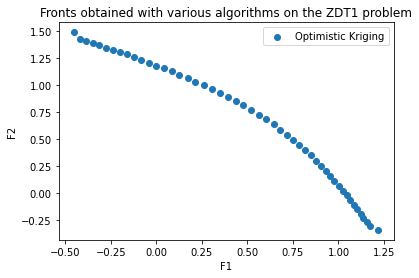

In [163]:
front_G_opt = evolver_G_opt.population.objectives - evolver_G_opt.population.uncertainity


G_opt = plt.scatter(x=front_G_opt[:,0], y=front_G_opt[:,1], label="Optimistic Kriging")

plt.title(f"Fronts obtained with various algorithms on the {problem_name} problem")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()